In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from os import path, makedirs, listdir
from tqdm import tqdm_notebook as tqdm
from lxml import etree
import standoffconverter
from sklearn.model_selection import train_test_split

import bodleian_downloader

import pandas as pd
import numpy as np

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

# Why not just regular expressions?

- Match on `Doc` objects, not just strings
- Match on tokens and token attributes
- Use the model's predictions
- Example: "duck" (verb) vs. "duck" (noun)

Notes: Compared to regular expressions, the matcher works with Doc and Token
objects instead of only strings.

It's also more flexible: you can search for texts but also other lexical
attributes.

You can even write rules that use the model's predictions.

For example, find the word "duck" only if it's a verb, not a noun.  
[(source Ines Montani)](https://raw.githubusercontent.com/ines/spacy-course/master/slides/chapter1_03_rule-based-matching.md)

# Match patterns

- Lists of dictionaries, one per token

- Match exact token texts

```python
[{'TEXT': 'iPhone'}, {'TEXT': 'X'}]
```

- Match lexical attributes

```python
[{'LOWER': 'iphone'}, {'LOWER': 'x'}]
```

- Match any token attributes

```python
[{'LEMMA': 'buy'}, {'POS': 'NOUN'}]
```

Notes: Match patterns are lists of dictionaries. Each dictionary describes one
token. The keys are the names of token attributes, mapped to their expected
values.

In this example, we're looking for two tokens with the text "iPhone" and "X".

We can also match on other token attributes. Here, we're looking for two tokens
whose lowercase forms equal "iphone" and "x".

We can even write patterns using attributes predicted by the model. Here, we're
matching a token with the lemma "buy", plus a noun. The lemma is the base form,
so this pattern would match phrases like "buying milk" or "bought flowers".

In [15]:
import spacy

# Import the Matcher
from spacy.matcher import Matcher

# Load a model and create the nlp object
nlp = spacy.load('en_core_web_sm')

# Initialize the matcher with the shared vocab
matcher = Matcher(nlp.vocab)

# Add the pattern to the matcher
pattern = [{'TEXT': 'iPhone'}, {'TEXT': 'X'}]
matcher.add('IPHONE_PATTERN', None, pattern)

# Process some text
doc = nlp("New iPhone X release date leaked.")

# Call the matcher on the doc
matches = matcher(doc)
for match_id, start, end in matches:
    # Get the matched span
    matched_span = doc[start:end]
    print(matched_span.text)

iPhone X


## [Rule-based Matcher Explorer](https://explosion.ai/demos/matcher)
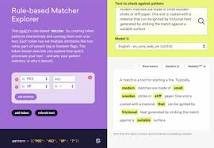




## Automatically create a list of ministries in George Orwell's *Nineteen eighty-four*

In [19]:
import requests 

_1984 = requests.get('http://gutenberg.net.au/ebooks01/0100021.txt')

In [43]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)

pattern = [{"ORTH": "Ministry"},
           {"LOWER": "of"},
           {"IS_ALPHA": True},
            ]
matcher.add("ministryof", None, pattern)

doc = nlp(_1984.text)

matches = matcher(doc)
ministries = []
for match_id, start, end in matches:
    if str(doc[start:end]) not in ministries:
        ministries.append(str(doc[start:end]))
ministries    

['Ministry of Truth',
 'Ministry of Love',
 'Ministry of Plenty',
 'Ministry of Peace',
 'Ministry of War']

# Phrase Matcher for stage directions

First, download Shakespeare plays that have annotations for stage directions.

In [3]:
standoffs = []

for fn in tqdm(bodleian_downloader.get_file_descriptors(), desc="download and extract xml"):

    tree = etree.fromstring(open(fn, "rb").read())

    so = standoffconverter.Standoff()
    so.from_lxml_tree(tree)

    standoffs.append(so)


## Preparing the data

In [4]:
train, test = train_test_split(standoffs, random_state=4123)

In [5]:
def extract_true_stage_directions(standoffs):
    stage_directions = []
    indices = []
    for standoff in standoffs:
        indices.append([])
        for annotation in standoff.standoffs:
            if annotation["tag"] == "{http://www.tei-c.org/ns/1.0}stage":
                stage_directions.append(standoff.plain[annotation["begin"]:annotation["end"]])
                indices[-1].append((annotation["begin"],annotation["end"]))
    return stage_directions, indices
                
train_sd,_ = extract_true_stage_directions(train)

## Creating some example matchers and validate
The validation function also shows you examples of fales matches (false negatives and false positives)

In [41]:
from spacy.matcher import Matcher
matcher = Matcher(nlp.vocab)


pattern = [{'ORTH': 'Enter'},
           {'IS_PUNCT': True}]

matcher.add('ENTER', None, pattern)


pattern = [{'ORTH': 'Enter'},
           {'POS': 'PROPN'},
           {'IS_PUNCT': True}]

matcher.add('ENTER_SOMEONE', None, pattern)

pattern = [{'ORTH': 'Exit'},
           {'IS_PUNCT': True}]

matcher.add('EXIT', None, pattern)

pattern = [{'ORTH': 'Exit'},
           {'POS': 'PROPN'},
           {'IS_PUNCT': True}]

matcher.add('EXIT_SOMEONE', None, pattern)


def validate_stage_directions(matcher, data):

    docs = [nlp(doc.plain) for doc in data]
    
    data_sd, data_indices = extract_true_stage_directions(data)
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    fn_examples = []
    fp_examples = []
    
    tp_match_names = []
    fp_match_names = []
    
    
    for idoc, doc in tqdm(enumerate(docs), total=len(docs)):
        
        ground_truth = np.zeros(len(doc.text)).astype(bool)
        prediction = np.zeros(len(doc.text)).astype(bool)
        for begin, end in data_indices[idoc]:
            ground_truth[begin:end] = True
            
        
        matches = matcher(doc)
        for match_id, begin, end in matches:
            prediction[doc[begin].idx:doc[end].idx + len(doc[end])] = True
            gt = ground_truth[doc[begin].idx:doc[end].idx + len(doc[end])]
            if gt.sum() < len(gt):
                fp_examples.append({
                    "phrase": doc[begin:end].text,
                    "phrase_with_context":doc[max(0, begin-5):min(len(doc),end+5)].text
                })
                fp_match_names.append(
                    nlp.vocab.strings[match_id]
                )
            else:
                tp_match_names.append(
                    nlp.vocab.strings[match_id]
                )
        
        for begin, end in data_indices[idoc]:
            if prediction[begin:end].sum() < len(prediction[begin:end]):
                fn_examples.append({
                    "phrase": doc.text[begin:end],
                    "phrase_with_context":doc.text[max(0,begin-25):min(len(doc.text), end + 25)]
                })

        tp += np.logical_and(ground_truth, prediction).sum()
        fn += np.logical_and(ground_truth, ~prediction).sum()
        fp += np.logical_and(~ground_truth, prediction).sum()
        tn += np.logical_and(~ground_truth, ~prediction).sum()

    precision = tp /(tp + fp) if fp > 0 or tp > 0 else 0
    recall = tp /(tp + fn) if tp > 0 or fn > 0 else 0
    f1_score = 2*tp / (2*tp + fp + fn) if tp > 0 or fp > 0 or fn > 0 else 0
    print("precision: {:.2f}, recall: {:.2f}, f1 {:.2f}".format(precision, recall, f1_score))
    
    
    printmd("**What has not been identified? For example:**")
    for ex_dict in np.random.choice(fn_examples, 3):
        for k,v in ex_dict.items():
            printmd("*" + k + "*")
            print(">", v)
    
    printmd("\n **What has been identified. although it is not a stage direction? For example:**")
    for ex_dict in np.random.choice(fp_examples, 3):
        for k,v in ex_dict.items():
            printmd("*" + k + "*")
            print(">", v)
            

    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    fig.suptitle('how often did a pattern apply?')
    
    keys, counts = np.unique(tp_match_names, return_counts=True)
    ax1.bar(keys,counts)
    ax1.set_title("correctly applied pattern")
    
    keys, counts = np.unique(fp_match_names, return_counts=True)
    ax2.bar(keys, counts)
    ax2.set_title("incorrectly applied pattern")
    
    
validate_stage_directions(matcher, train[:2])



> <ipython-input-41-08d2e578daf1>(61)validate_stage_directions()
-> print(doc[begin:end])
(Pdb) gt
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])
(Pdb) len(doc[end])
41
(Pdb) doc[end]

                  
                     
(Pdb) len(doc[end].text)
41
(Pdb) q


BdbQuit: 